In [15]:
import numpy as np
import os
import sys
from keras.preprocessing.text import Tokenizer
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GRU
from keras.optimizers import RMSprop
import pandas as pd

sys.path.append('../')
from utils import acc_plot, loss_plot

## Conv1D 
Less computationally demanding alternative for RNNs. It does not recognize order.

In [2]:
max_features = 10000
maxlen = 500
batch_size = 32

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

X_train.shape, y_train.shape

((25000, 500), (25000,))

In [7]:
model = Sequential([
    Embedding(max_features, 128, input_length=maxlen),
    Conv1D(32, 7, activation='relu'),
    MaxPooling1D(5),
    Conv1D(32, 7, activation='relu'),
    GlobalMaxPooling1D(), # returns only one value, it performs pooling on entire map, not a chunk (e.g of size 2x2 like in CNNs)
    Dense(1)
])

model.summary()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-4), metrics=['accuracy'])
#
# 500x7 Input x 7x32 Kernel = 500x32 Output
# 500x7 Input x 1x32 Kernel = 500x1 Output

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 494, 32)           28704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 98, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                

GlobalMaxPooling1D() usually works better than Flatten in cases where one value in the sequence is more significant than the others. For example, in the case of text classification, when the single most significant feature in the sequence is important, GlobalMaxPooling1D() may be more effective than Flatten, because it returns only the single value from the entire sequence that is most significant for classification.

On the other hand, Flatten is more suitable in cases where each feature in the sequence is similarly relevant to the problem, and using GlobalMaxPooling1D() may lead to a loss of information. For example, in image processing, where every pixel is important for object identification, Flatten may be a better choice than GlobalMaxPooling1D().

In [9]:
history = model.fit(
    X_train, 
    y_train,
    batch_size=128, 
    epochs=10,
    validation_split=0.2,
    verbose=0
) 
# very fast

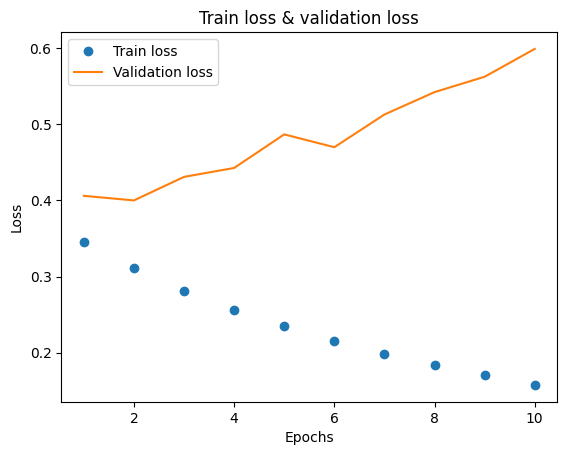

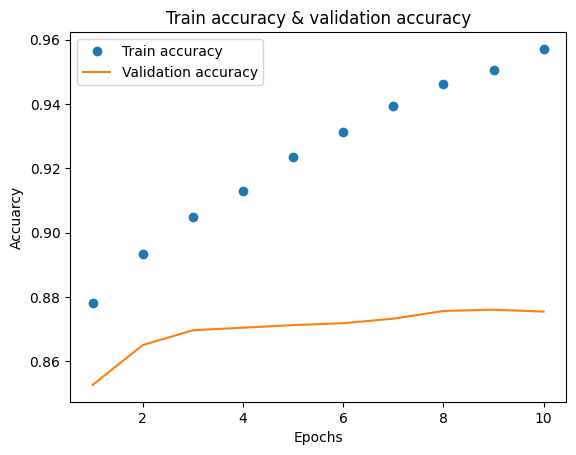

In [10]:
history_dict = history.history
loss_plot(history_dict, epochs=10)
acc_plot(history_dict, epochs=10)

## Conv1D + RNN
Good combo for long sequences - firstly convolutional layers create shorter sequence than the one from input and then recurrent layers making a prediction.

In [14]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df.drop(['Date Time'], axis=1, inplace=True)
means = df[:200000].mean(axis=0)
stds = df[:200000].std(axis=0)
df = (df - means) / stds
X = df.values

def generator(data, loopback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + loopback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + loopback, max_index, size=batch_size)
        else:
            if i + batch_size > max_index:
                i = min_index + loopback
                
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), loopback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - loopback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

loopback = 1440 
step = 3 # we take one sample every 30min
delay = 144 
batch_size = 128

train_gen = generator(
    X,
    loopback=loopback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True
)

val_gen = generator(
    X, 
    loopback=loopback,
    delay=delay,
    min_index=200001,
    max_index=300000
)

test_gen = generator(
    X, 
    loopback=loopback,
    delay=delay,
    min_index=300001,
    max_index=None
)

val_steps = (300000 - 200001 - loopback) // batch_size
test_steps = (len(X) - 300001 - loopback) // batch_size

In [18]:
model = Sequential([
    Conv1D(32, 5, input_shape=(batch_size, X.shape[-1])),
    MaxPooling1D(3),
    Conv1D(32, 5, activation='relu'),
    MaxPooling1D(3),
    GRU(32), # we should add dropout and recurrent dropout to prevent overfitting
    Dense(1)
])

model.compile(loss='mae', optimizer=RMSprop())

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps,
    verbose=0
)

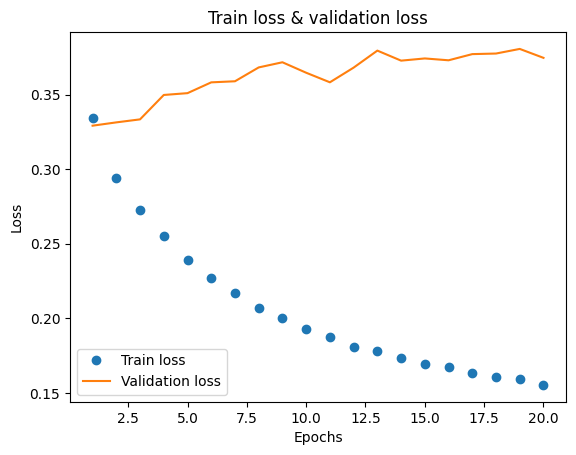

In [21]:
history_dict = history.history
loss_plot(history_dict, epochs=20)